## Set up

In [1]:
import pickle
from copy import deepcopy
import pandas as pd
import numpy as np
from osgeo.gdalconst import *
from osgeo import gdal
from scipy.ndimage import gaussian_filter, median_filter
#visualization
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, balanced_accuracy_score

In [2]:
#import custom functions
from custom_functions import *

## Combine Forests with different features

In [3]:
#load in models - 14_13
forest_14 = pickle.load(open('../models/forest14.sav', 'rb'))
forest_13 = pickle.load(open('../models/forest_13.sav', 'rb'))

In [ ]:
#load in models
forest_14 = pickle.load(open('../models/forest14.sav', 'rb'))
forest_15 = pickle.load(open('../models/forest15.sav', 'rb'))
forest_13 = pickle.load(open('../models/forest_13.sav', 'rb'))
xgb_bin14_v2 = pickle.load(open('../models/xgb_bin14_v2.sav', 'rb'))

In [ ]:
#load in models
forest_15 = pickle.load(open('../models/forest15.sav', 'rb'))
forest_16 = pickle.load(open('../models/forest_16.sav', 'rb'))
xgb_bin14 = pickle.load(open('../models/xgb_bin14.sav', 'rb'))

### Demo test

#### Process and predict options

Run different cells for different combined models. See `evaluation_legend.md` for more information.

In [4]:
#Processing for 14_13
process_14_13 = {
                       'target_edge': ['B8A', None],
                        'target_outlier' : ['B01f', False],
                        'geocoords': [False, False],
                        'gaussian' : [False, True],
                        'clustering' : [False, '../models/kcluster_13.sav'],
                        'calculate_layers' : [True, True]}
binary_14_13 = None

combo_pred, y_true = predict_combo([forest_14, forest_13], '../data_tests/demo_site.csv',  '../data_tests/demo/raws',
                                  process_dict = process_14_13)
#combine predictions based on class list
final_pred = combine_pred(combo_pred, class_lists = [[15]], binary = binary_14_13)

getting edge


In [15]:
final_pred.shape

(5250000, 1)

In [ ]:
#Processing for 14_bbin14_13
process_14_bin14_13 = {
                       'target_edge': ['B8A', None, None],
                        'target_outlier' : ['B01f', False, False],
                        'gaussian' : [False, False, True],
                        'geocoords': [False, False, False],
                        'clustering' : [False, False, '../models/kcluster_13.sav'],
                        'calculate_layers' : [True, 'Extra', True]}
binary_14_bin14_13 = {'model': [1], 'class': [14]}

combo_pred, y_true = predict_combo([forest_14, xgb_bin14, forest_13], '../data_tests/demo_site.csv',  '../data_tests/demo/raws',
                                  process_dict = process_14_bin14_13, binary = binary_14_bin14_13)
#combine predictions based on class list
final_pred = combine_pred(combo_pred, class_lists = [[14], [15]], binary = binary_14_bin14_13)

TypeError: predict_combo() got multiple values for argument 'process_dict'

In [ ]:
#Processing for 15_bbin14_16
process_15_bin14_16 = {
                       'target_edge': ['B8A', None, 'B8A'],
                        'geocoords': [True, False, True],
                        'target_outlier' : [False, False, 'B01f'],
                        'gaussian' : [False, False, True],
                        'clustering' : [False, False, False],
                        'calculate_layers' : [True, 'Extra', True]}
binary_15_bin14_16 = {'model': [1], 'class': [14]}

#generate process data and predicitons from each model
combo_pred_list, y_true = predict_combo([forest_15, xgb_bin14, forest_16], '../data_tests/demo_site.csv',  '../data_tests/demo/raws',
                                   process_dict = process_15_bin14_16, binary = binary_15_bin14_16)

#combine predictions based on class list
combo_pred = combine_pred(combo_pred_list, class_lists = [[14], [15]], binary = binary_15_bin14_16)

#### Evaluation

Text(0.5, 1.0, 'True')

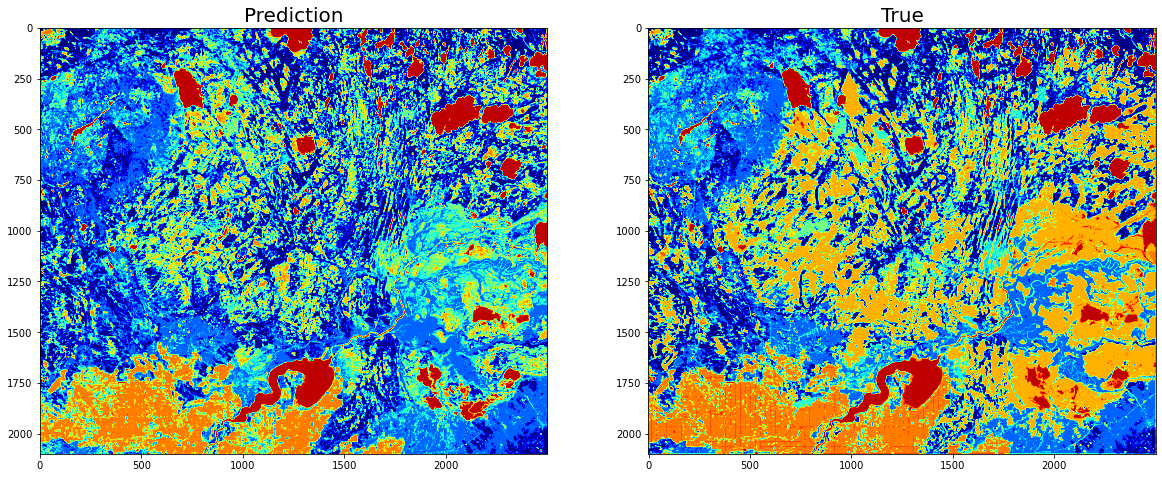

In [6]:
#plot classification maps
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side

cmap = cm.get_cmap('jet', 19)

ax1.imshow(np.asarray(final_pred).reshape(2100, 2500), vmin = 1, vmax = 19, cmap = cmap)
ax2.imshow(np.asarray(y_true).reshape(2100, 2500),  vmin = 1, vmax = 19, cmap = cmap)

ax1.set_title('Prediction', fontsize = 20)
ax2.set_title('True', fontsize = 20)

In [25]:
fig.savefig(os.path.join('evaluation', 'demo/combo', '14_13_comparison.png'))

In [ ]:
#accuracy
print(balanced_accuracy_score(y_true, final_pred))
print(accuracy_score(y_true, final_pred))

#confusion matrix
cm_forest = confusion_matrix(y_true, final_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

In [5]:
print(classification_report(y_true, final_pred, zero_division = 1))

              precision    recall  f1-score   support

           1       0.65      0.81      0.72   1295963
           2       0.00      0.75      0.00       229
           5       0.62      0.61      0.61    754883
           6       0.35      0.19      0.24    319587
           8       0.18      0.25      0.21    327876
          10       0.08      0.44      0.14     32747
          12       0.00      0.00      0.00        96
          13       0.00      1.00      0.00         0
          14       0.68      0.40      0.51   1786474
          15       0.73      0.82      0.77    389203
          16       0.07      0.01      0.02      8532
          17       0.13      0.05      0.08     24855
          18       0.84      0.91      0.87    309555

    accuracy                           0.57   5250000
   macro avg       0.33      0.48      0.32   5250000
weighted avg       0.62      0.57      0.58   5250000



In [ ]:
#OPTIONAL: save matrix and map as versions
#save confusion matrix
cm_forest_fig.figure_.savefig(os.path.join('evaluation', 'demo/combo', '15_xgbin14_16_cm.png'))

#save prediction map
prediction_map.figure.savefig(os.path.join('evaluation', 'demo/combo', '15_xgbin14_16_map.png'))

### Random extent test

#### Combination

In [ ]:
combo_pred_list = predict_combo([forest_15, xgb_bin14, forest_16], None, '../data_tests/calgary/raws', index = [-14, -11], 
                                   process_dict = process_15_bin14_16, binary = binary_15_bin14_16, nrcan_name = 'NRCAN_transformed.tif')

In [ ]:
#combine predictions based on class list
combo_pred = combine_pred(combo_pred_list, class_lists = [[14], [15]], binary = binary_15_bin14_16)

In [ ]:
cal_raws = gdal_to_dataframe('../data_tests/calgary/raws')
y_true = cal_raws['y']



In [ ]:
combo_pred = combine_pred(combo_pred_list, class_lists = [[14], [15]], binary = binary_15_bin14_16)

In [ ]:
combo_pred, y_true = predict_combo([forest_14, xgb_bin14, forest_13], None, '../data_tests/calgary/raws', index = [-14, -11], 
                                   process_dict = process_10_bin14_13, binary = binary_10_bin14_13, nrcan_name = 'NRCAN_transformed.tif')

In [ ]:
#accuracy
print(balanced_accuracy_score(y_true, combo_pred))
print(accuracy_score(y_true, combo_pred))

#confusion matrix
cm_forest = confusion_matrix(y_true, combo_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

In [ ]:
map_pred = np.asarray(combo_pred.values).reshape(926, 1250)
cmap = cm.get_cmap('jet', 19)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

In [ ]:
map_pred = np.asarray(y_true).reshape(926, 1250)
cmap = cm.get_cmap('jet', 19)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

In [ ]:
print(classification_report(y_true, combo_pred, zero_division = 1))

#### Forest only

In [ ]:
#X_ran, y_ran = process_data(None, '../data_tests/trois/raws', nrcan_name = 'NRCAN_transformed.tif', index = [-14, -11], gaussian = True, clustering = 'models/kcluster_13.sav', calculate_layers = True)
X_ran, y_ran = process_data(None, '../data_tests/calgary/raws', nrcan_name = 'NRCAN_transformed.tif', index = [-14, -11], target_edge = 'B8A', geocoords = True,target_outlier = 'B01f', calculate_layers = True, gaussian = True)

In [ ]:
forest_pred = forest_14.predict(X_ran)

In [ ]:
map_pred = np.asarray(forest_pred).reshape(926, 1250)
cmap = cm.get_cmap('jet', 19)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

In [ ]:
map_pred = np.asarray(y_ran.values).reshape(926, 1250)
cmap = cm.get_cmap('jet', 19)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

In [ ]:
print(balanced_accuracy_score(y_ran, forest_pred))
print(accuracy_score(y_ran, forest_pred))

#confusion matrix
cm_forest = confusion_matrix(y_true, forest_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest, display_labels = forest_10.classes_)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

In [ ]:
print(classification_report(y_true, combo_pred, zero_division = 1))